# CAB420 Classification, Bonus Example: Bag of Words (and TF-IDF, and Naive Bayes)
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

A common characteristic of the majority of machine learning methods (and certainly classifiers) is that they like a fixed size input. By this, I mean that our input data is always the same size. When dealing with tabular data, this isn't an issue. We have a fixed number of columns and every sample has the same set of columns. Even with data like images, this can be managed by resizing images. Text however, is a bit harder. 

If we're trying to classify articles into their underlying topic, it's very unlikely that we're going to see every article being the same length. We saw this issue with the beer names example, and we solved this by padding the sequences so that they were all the same length. But this approach has other issues:
* It can greatly increase the size of our features, which can make our classifiers harder to train.
* The feature representation makes the model dependent on the order of the data, i.e. it means that the system needs to have the same words in the same places.

Bag of Words is a feature transform that allows us to go from a variable length sample to a fixed length representation. To do this, we transform our data into a histogram, that measure how many instances of each word we have. There are a few steps involved in this:
* Clean the text. This means usually converting to lower case, removing punctuation, removing stop words, performing lemmatisation
* Build a dictionary. This contains all possible words. We may at this point choose to exlude words that are very rare (if they're very rare, it's harder for our model to understand their meaning), very common (if they're very common, they're probably not much use for discriminating between classes), or just take the top $N$ words to avoid having histograms that are too big.
* Convert our text into a *Bow of Words* via the dictionary. This will take us from a variable length text sample to a fixed length histogram. Each word in the dictionary will have an entry in the histogram. The value in the histogram will be how many times that word occurs in the sample.

Bag of words solves our issues of variable length sequences, however it's not without problems:
* It can result in very large feature representations. If we have a dictionary of 10,000 words, we'll transform each sample into a length 10,000 vector; even if the original samples is only a few words of text.
* We destroy order. The histogram contains no information on the order of words, so information is lost.
* The histogram representation is not invariant to the length of the document. We get the same sized representation, but a longer document will have much bigger values in the histogram, as there are more words to count.

There are various solutions (or partial solutions) to each of the above issues, which we'll explore below.

### Where does this fit into all the other CAB420 content?

This fits alongside our other classification content, presenting an alternate feature representation that allows us to use regular classifiers with variable length data. This also relates to the sequence content, and other bonus examples that will come later (isn't that exciting) such as visual bag of words.

In [1]:
# import the natural language toolkit, and download some resources that we need
import nltk
from nltk.corpus import reuters
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
# regular expressions
import re
# feature extraction methods
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# classifiers
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
# data manipulation
from scipy.sparse import vstack
# plotting
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
# for measuring time
import time
# numpy, because you need numpy
import numpy

[nltk_data] Downloading package reuters to
[nltk_data]     /home/denman/cab420/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/denman/cab420/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/denman/cab420/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data and Data Loading

We're using the reuters newswire dataset today. This is a collection of news articles and the topics of those articles. The overall idea is to classify the articles into the topics, based on the article contents. 

If you trawl around the internet, you'll find a lot of copies of this data, in various forms (I believe the original release is [here](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection)). I'm going to use the version of the dataset that resides in the [Natural Language Toolkit](https://www.nltk.org/).

Let's start by getting a bit of info about the Reuters dataset (adapted from [here](https://miguelmalvarez.com/2015/03/20/classifying-reuters-21578-collection-with-python-representing-the-data/)).

In [2]:
def collection_stats():
    # List of documents
    documents = reuters.fileids()
    print(str(len(documents)) + " documents");

    train_docs = list(filter(lambda doc: doc.startswith("train"), documents));
    print(str(len(train_docs)) + " total train documents");

    test_docs = list(filter(lambda doc: doc.startswith("test"), documents));
    print(str(len(test_docs)) + " total test documents");

    # List of categories
    categories = reuters.categories();
    print(str(len(categories)) + " categories");
    print(categories)

    # Documents in a category
    category_docs = reuters.fileids("acq");

    # Words for a document
    document_id = category_docs[0]
    document_words = reuters.words(category_docs[0]);
    print(document_words);

    # Raw document
    print(reuters.raw(document_id));    

collection_stats()

10788 documents
7769 total train documents
3019 total test documents
90 categories
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']
['SUMIT

The above info gives us a sense of what we're dealing with - it really is just news articles. We have $90$ categories, yet only $11,000$ articles. Closer inspection of this reveals that we have a couple of issues:
* A number of categories have a very small number of articles.
* A single article can have multiple categories.

Given the above, and to simplify the example somewhat, I will do the following:
* Remove topics which have fewer samples than some limit
* Remove articles that have multiple topics

In [3]:
# get the number of samples in each category. Save the category names of those with more than
# min_samples samples
def filter_category_list(min_samples = 200):

    categories = reuters.categories();

    categories_to_keep = []
    for c in categories:
        if (len(reuters.fileids(c)) >= min_samples):
            categories_to_keep.append(c)

    return categories_to_keep

# filter the data and pull out the raw text and the label for each article
train_docs = []
train_labels = []
test_docs = []
test_labels = []
# get list of categories to keep
cats_to_keep = filter_category_list()

# loop through all documents
for doc_id in reuters.fileids():
    # make sure that:
    #  - the document only has one category
    #  - that category is one of those that we wish to keep
    if (len(reuters.categories(doc_id)) == 1) & (reuters.categories(doc_id)[0] in cats_to_keep):
        # put the data in either train or test depending on the split that the sample comes from
        if doc_id.startswith("train"):
            train_docs.append(reuters.raw(doc_id))
            train_labels.append(reuters.categories(doc_id)[0])
        else:
            test_docs.append(reuters.raw(doc_id))
            test_labels.append(reuters.categories(doc_id)[0])

# sanity check size printing
print(len(train_docs))
print(len(train_labels))
print(len(test_docs))
print(len(test_labels))

5501
5501
2190
2190


We've shed a fair bit of data here. One thing to note is the order that I've done these operations in means that I won't have at least $200$ examples of each topic. The topic count thresholding is applied to the entire dataset, including those samples that have multiple topics. As such, a number of topics will actually have fewer than $200$ samples - though there will still be enough samples to have a reasonable go at classification.

### Preparing the Text Data

We're now at the point where we need to clean and tokenise our data. In particular we want to:
* Convert all our data to lower case.
* Remove stop words
* Perform lemmatisation
* Remove punctuation and other invalid characters
* Split the resulting string so that we have a list of strings, each list element containing a single word (token)

We'll do this with a single function, *tokenize* (which was borrowed from [here](https://miguelmalvarez.com/2015/03/20/classifying-reuters-21578-collection-with-python-representing-the-data/)). There are lots of ways to do this, and sklearn will use a default tokeniser to do pretty much the same thing that we're doing here. However, writing your own tokeniser does give you much more power to tweak things if it's needed.

We have another function here *bow*, which will set up our bow transform. This really is just a wrapped for the *CountVectorizer* object, and there is no real need to wrap this up in a function, but anyway. That said, it's worth looking at what arguments this is taking it, and what it's doing. Starting with what this does, this will build our dictionary that will allow us to transfrom from a lump of text into a bag of words. To do this, we need to tell it how to tokenize the text, and then what words to actually consider. This bring us to the arguments:
* docs: The list of documents to process
* tokenizer: A tokenizer to use to clean the data. If none, the default one in sklearn will be used.
* ngram_range: By default this is (1,1), which means the vectorizer will look at subsequences between the length of 1 and 1, i.e. it will only consider individual words. If we made this (1,3), we'd have the vectorizer look at individual words, pairs of consecutive words, and groups of three consecutive words (i.e. we'd be able to capture some order information). This will make more sense later on when we start to play with it.
* min_df: the minimum document frequency. This can be specified as either a positive integer, or a float in the range [0..1]. As an integer, it's saying that any ngram (i.e. word, or short group of consecutive words) that occurs in less than min_df documents should be ignored. The float version is looking at percentage of documents. This allows us to remove ngrams that appear very rarely, and are thus (potentially) hard to model.
* max_df: the maximum document frequency. Really the inverse of the min_df, and again can be specified as either an integer or  a float in [0..1]. Our default of 0.9 is saying that any ngram that occurs in over 90% of documents should be ignored. This will get rid of very common ngrams, which likely have little use in separating classes as they occur everywhere.
* max_features: an upper bound on the size of the dictionary. Bigger values will allow larger dictionaries. The most common max_features ngrams will be kept, after removing those that are too common or too rare. This can be used to reduce the size of the resultant feature vector, but may also remove useful info.

We then have a function to apply the BoW transform to a corpus, and a function to do a bit of display for us.

In [4]:
# tokensize some text
def tokenize(text, min_length = 3, stopwords = stopwords.words("english")):
    # convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text));
    # remove stopwords
    words = [word for word in words if word not in stopwords]
    # lemmatisation
    tokens = (list(map(lambda token: PorterStemmer().stem(token), words)));
    # filter using regular expression
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token)>=min_length, tokens));
    # return tokens
    return filtered_tokens    

# create bag-of-words transform
def bow(docs, tokenizer=None, ngram_range = (1,1), min_df = 3, max_df = 0.90, max_features = 500):
    # create bow object
    bow = CountVectorizer(tokenizer=tokenizer, min_df=min_df, max_df=max_df, \
                            max_features=max_features, ngram_range=ngram_range)
    # fit bow object to the provided data
    bow.fit(docs)
    return bow

# transform a corpus
def transform_corpus(corpus, representer):
    X = []
    # loop through the corpus and transform each document. note that the representer transform function
    # returns a sparse vector
    for x in corpus:        
        X.append(representer.transform([x]))
    # use vstack to append sparse vectors
    return vstack(X)

# get the values of each feature in a transformed representation. Useful for display only
def feature_values(doc, representer):
    # transform the document
    doc_representation = representer.transform([doc])
    # get the features
    features = representer.get_feature_names_out()
    # create tuples of the feature count and the word
    return [(features[index], doc_representation[0, index]) for index in doc_representation.nonzero()[1]]

# transform some data - note that the number of words here is really rather small. This is not the optimal number.
num_words = 100
bow_representer = bow(train_docs, tokenizer=tokenize, max_features=num_words)
train_bow = transform_corpus(train_docs, bow_representer)
test_bow = transform_corpus(test_docs, bow_representer)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Let's have a look at the first sample here after the transform. We'll look at the "raw" bag of words representation, and the result of feature_values to understand what this is showing.

In [5]:
print(train_bow[0])

  (0, 0)	1
  (0, 3)	2
  (0, 13)	1
  (0, 15)	3
  (0, 16)	4
  (0, 18)	1
  (0, 21)	4
  (0, 28)	1
  (0, 33)	1
  (0, 34)	2
  (0, 35)	1
  (0, 36)	1
  (0, 46)	1
  (0, 50)	1
  (0, 59)	1
  (0, 60)	1
  (0, 61)	1
  (0, 62)	2
  (0, 63)	2
  (0, 64)	1
  (0, 65)	3
  (0, 67)	1
  (0, 77)	7
  (0, 78)	2
  (0, 83)	5
  (0, 88)	2
  (0, 93)	1
  (0, 98)	3
  (0, 99)	1


First up, the feature for this document. We've gone from rich text to a sparse vector. What I mean by sparse vector is that we only store the non-zero values. We have 100 words in our BoW dictionary, so each document is represented by a length 100 vector - but clearly we've not stored 100 values. BoW often results in very sparse features (i.e. most of the values are 0). To save memory, these are often represented as sparse vectors where only the non-zero elements are stored. With only 100 words in our dictionary this doesn't make much of a difference here.

From this, we can see for example that the 77th word in the dictionary has 7 occurances in the documents. Essentially, this representation tells us what words occur and how frequently.

In [6]:
print(feature_values(train_docs[0], bow_representer))

[('acquir', 1), ('also', 2), ('buy', 1), ('common', 3), ('compani', 4), ('current', 1), ('dlr', 4), ('five', 1), ('hold', 1), ('inc', 2), ('includ', 1), ('increas', 1), ('market', 1), ('mln', 1), ('one', 1), ('oper', 1), ('pay', 1), ('pct', 2), ('per', 2), ('plan', 1), ('price', 3), ('product', 1), ('said', 7), ('sale', 2), ('share', 5), ('stock', 2), ('total', 1), ('would', 3), ('year', 1)]


The feature_values function gives us a bit more info, and shows us what the actual words are. So we can see that it's "said" that appeared 7 times. The information here is really no different from what we had above, it's just presented in a way that's a bit easier to understand.

We can visualise a bunch of documents and get a bit more of a sense of what's happening with our BoW.

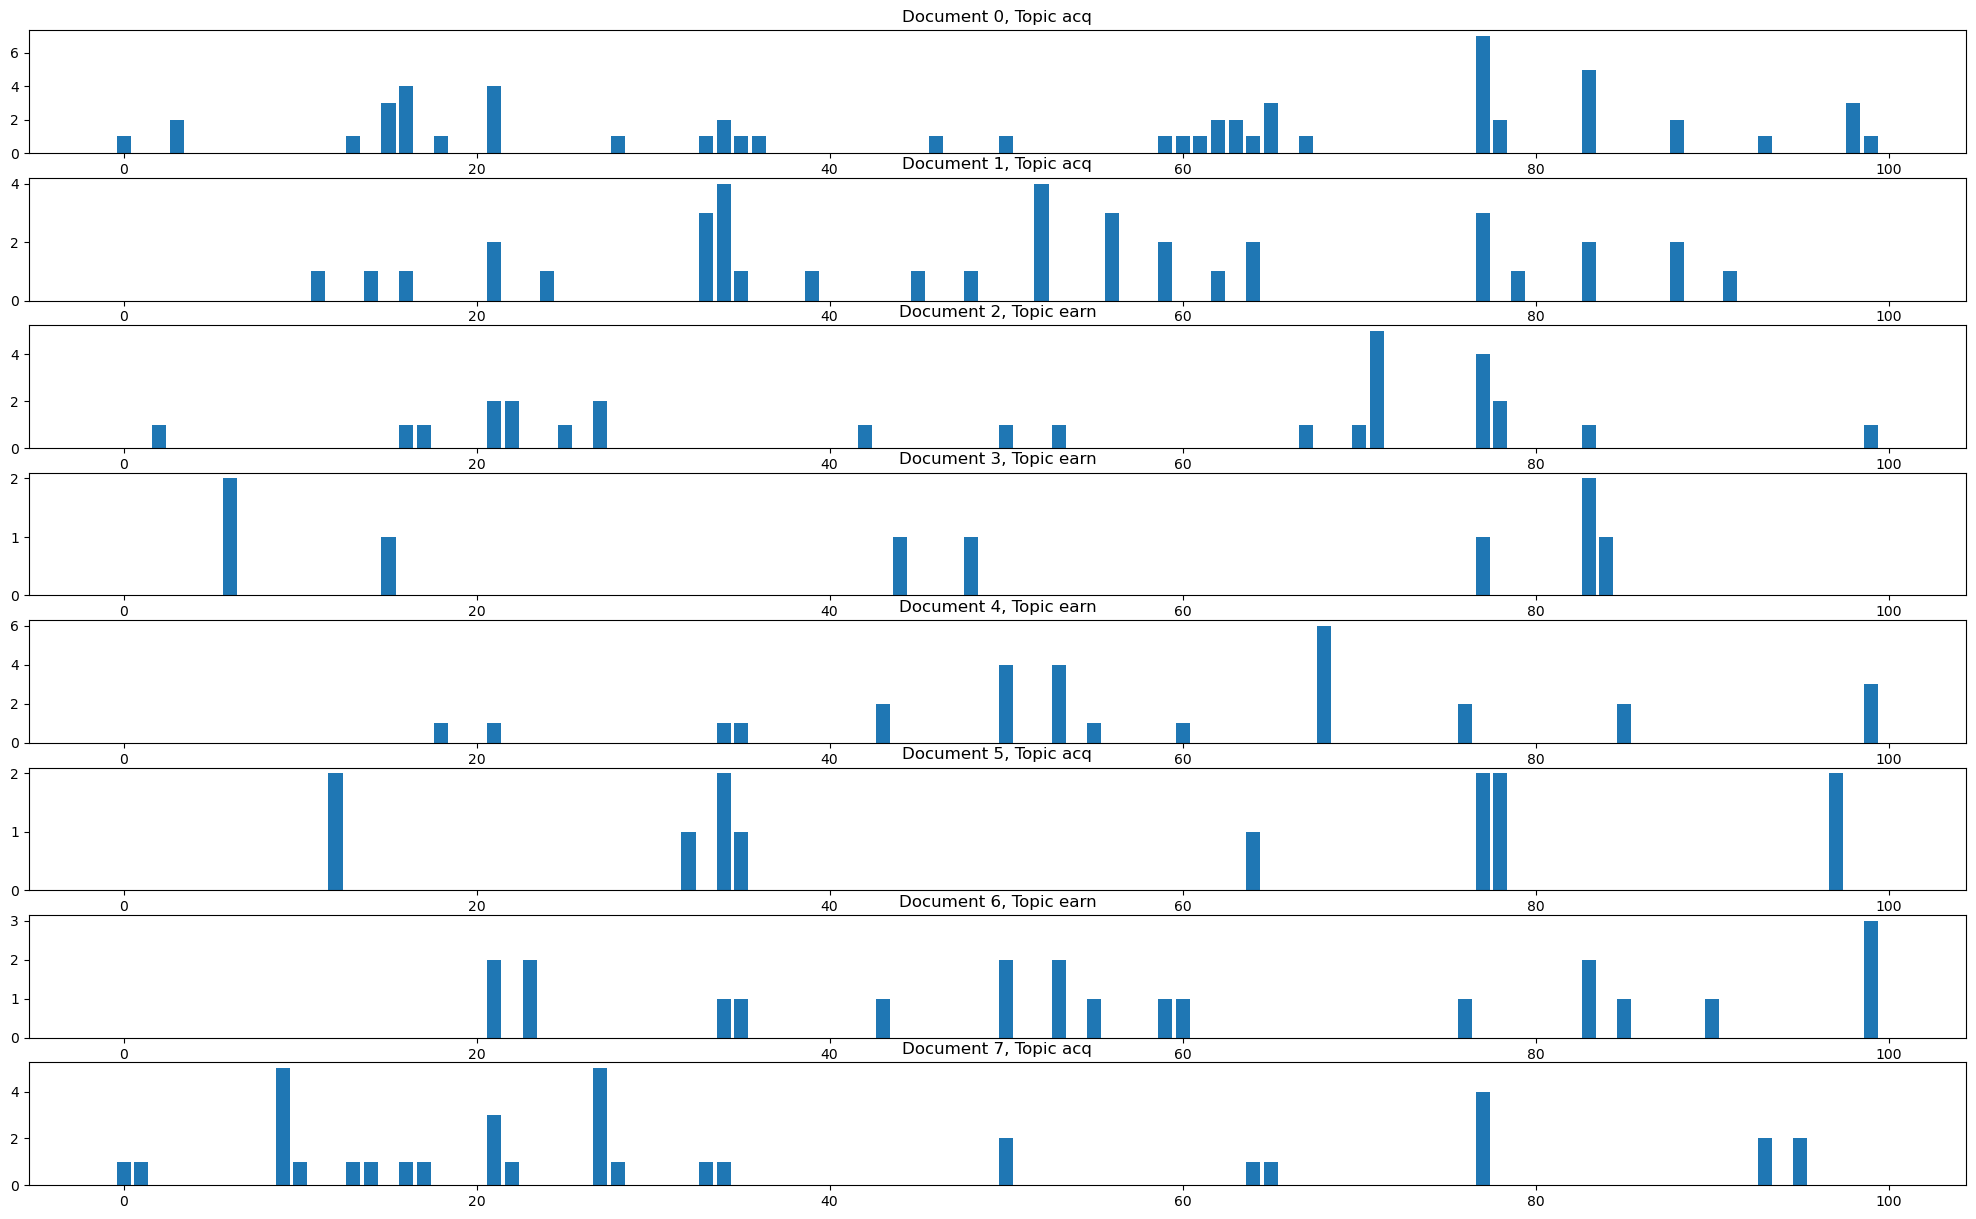

In [7]:
fig = plt.figure(figsize=[25, 15])
num_plots = 8
for i in range(num_plots):
    ax = fig.add_subplot(num_plots, 1, i+1)
    ax.bar(x = numpy.arange(0, num_words, 1), height = numpy.reshape(train_bow[i,:].toarray(), -1));
    ax.set_title('Document %d, Topic %s' % (i, train_labels[i]))

From the above, we've got 8 documents that belong to either *acq* or *earn*, and we can see that different classes tend to have different words. This is really how BoW does it's thing. It relies on there being words (or phrases when using ngrams) that are unique to a class.

### Classifying Stuff with BoW

Let's throw this at a classifier now. We'll start with an SVM. At this point, we have a representation that we can throw straight at an SVM, so let's do that.

              precision    recall  f1-score   support

         acq       0.94      0.94      0.94       696
       crude       0.94      0.84      0.89       121
        earn       0.98      0.98      0.98      1083
       grain       0.17      0.30      0.21        10
    interest       0.83      0.84      0.83        81
    money-fx       0.68      0.61      0.64        87
        ship       0.53      0.58      0.55        36
       trade       0.84      0.84      0.84        76

    accuracy                           0.93      2190
   macro avg       0.74      0.74      0.74      2190
weighted avg       0.93      0.93      0.93      2190

That SVM took 0 second to train, and 1 to evaluate


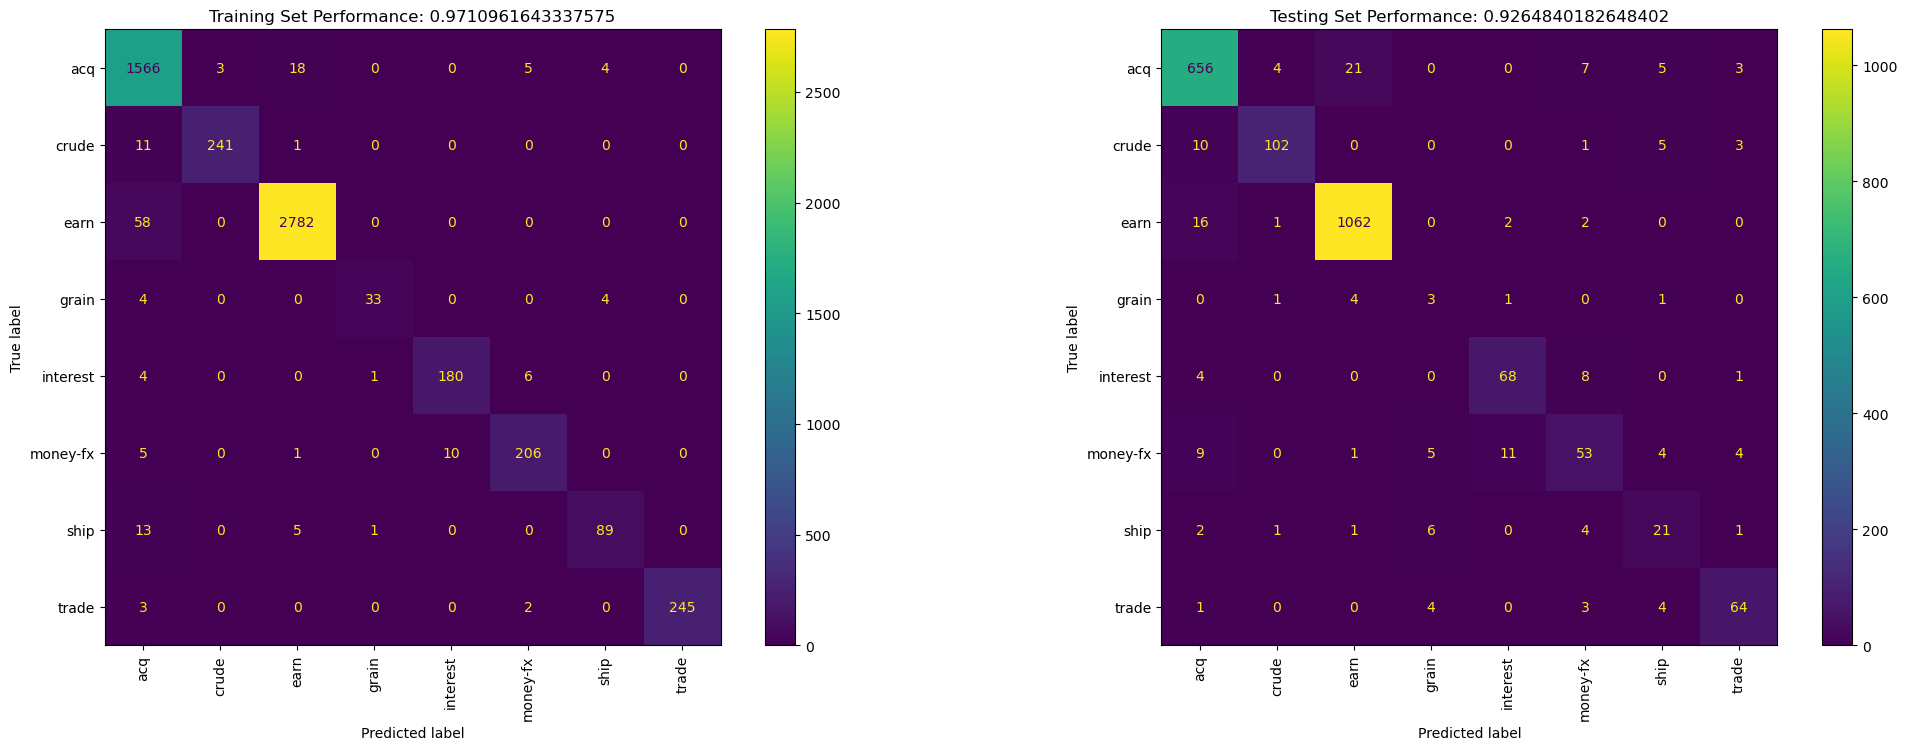

In [8]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));
    print(classification_report(Y_test, pred))
    
svm_start = time.process_time()
svm_bow = SVC(kernel='linear').fit(train_bow, train_labels)
svm_train_end = time.process_time()
eval_model(svm_bow, train_bow, train_labels, test_bow, test_labels)
svm_eval_end = time.process_time()
print('That SVM took %d second to train, and %d to evaluate' % (svm_train_end - svm_start, svm_eval_end - svm_train_end))

This works ok.

SVMs often work quite well with BoW features. Linear SVMs in particular like high dimensional sparse features which is what BoW generally results in. Also, the idea of finding words that are unique to a topic, and dividing classes based on this makes sense with an SVM. 

That said, SVMs can have some downsides. In particular:
* SVMs get slow where there is a lot of data
* We have to tune the SVM hyper-parameters, which will also be sensitive to the parameters of our BoW extraction
* If words are common to multiple classes, but vary in proportion, the intuition behind what the SVM is doing get's a bit muddier

One other model that we see a lot with text processing and bag-of-words is Naive Bayes. So let's have a go with that.

### Naive Bayes

Naive Bayes is really quite a simple method and is simply based on how frequently different words occur for different classes. Despite it's simplicity, it often works quite well. We'll try to explain it briefly. 

Unsurprisingly, Naive Bayes makes use of Bayes Rule:

$P(y|x) = \frac{P(x|y)P(y)}{P(x)}$

Here we have the following:
* $y$ is a class label.
* $x$ is an input feature. With our bag of words, this is really $[x_1, x_2, x_3, ..., x_N]$, where $N$ is the size of our dictionary and each of $x_1, x_2, ...$ are the number of instances of that word appearing (i.e. our bag of words features).
* $P(y|x)$ is the posterior probability of $y$ (our class) given the predictor $x$.
* $P(x|y)$ is the probability of observing $x$ given that we have class $Y$
* $P(y)$ is the prior probability of class $y$, i.e. how likely class $y$ is to occur in the data.
* $P(x)$ is the prior probability of $x$, i.e. how likely are the words to have occured.

We can actually calculate all of stuff on the right ($P(x|y), P(y) and P(x)$) from the training data. Though $P(x|y)$ becomes annoying as our feature dimension gets large, i.e. as $N$ (our number of words) increases. Unfortunatley, with NLP this is often quite big. 

This is where the Naive bit comes in. We assume (pretend, hope?) that all features are independent. If all of our x features are independent, then

$P(x_1,x_2,...x_N|y) = P(x_1|y)P(x_2|y)...P(x_N|y)$ 

which makes $P(x|y)$ a lot simpler to figure out by simply looking at the frequency of features occuring. In fact, all of the things we need to estimate ($P(x|y)$, $P(x)$ and $P(y)$) can be derived just by looking at the data and counting how often things occur. 

#### Naive Bayes Flavours

[sklearn has six versions](https://scikit-learn.org/stable/modules/naive_bayes.html) of Naive Bayes. The main difference between each of these is what assumptions are made regarding the distribution of $P(x_i|y)$. For text processing, we're going to be using [multinomial naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) which uses a multinomial distribution and is thus suitable for use with feature counts, like we get from bag of words.

#### Smoothing, and why we need it

One problem we can get with Naive Bayes is when we get words that have never occured for a class during training. Let's say we have some fairly common and uninteresting word, $x_{4}$, but for whatever reason it never popped up during training for a given class, $y_c$. This means that the probability of that word occuring given that class is $P(x_4|y_c) = 0$, and thus even if a heap of other evidence overwhelmingly points towards this sample being class $y_c$, we'll end up with a probablity of $0$. Here, we can use a smoothing process to avoid this. 

Handily, this is on by default in sklearn. So unless you have reason to turn this off, just leave it on. 

#### Naive Bayes in Action

Let's have a go at this now, first with our $N=100$ bag of words and everything on defaults.

              precision    recall  f1-score   support

         acq       0.93      0.95      0.94       696
       crude       0.90      0.86      0.88       121
        earn       0.98      0.96      0.97      1083
       grain       0.33      0.20      0.25        10
    interest       0.82      0.77      0.79        81
    money-fx       0.72      0.67      0.69        87
        ship       0.52      0.61      0.56        36
       trade       0.76      0.91      0.83        76

    accuracy                           0.92      2190
   macro avg       0.74      0.74      0.74      2190
weighted avg       0.92      0.92      0.92      2190

Naive Bayes took 0 second to train, and 0 to evaluate


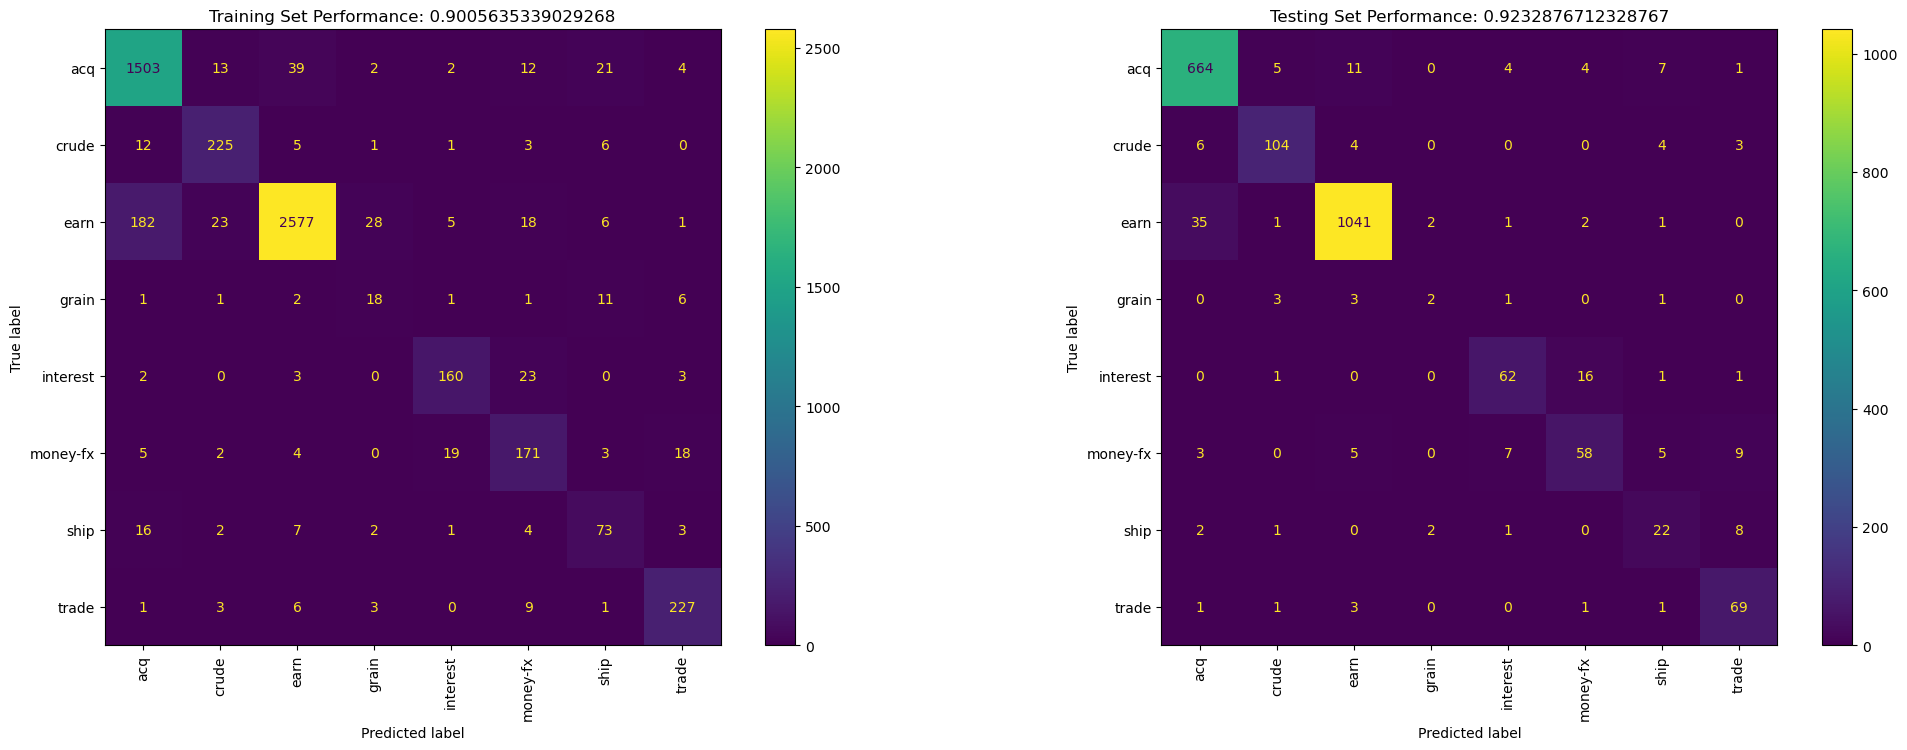

In [9]:
nb_start = time.process_time()
nb = MultinomialNB().fit(train_bow, train_labels)
nb_train_end = time.process_time()
eval_model(nb, train_bow, train_labels, test_bow, test_labels)
nb_eval_end = time.process_time()
print('Naive Bayes took %d second to train, and %d to evaluate' % (nb_train_end - nb_start, nb_eval_end - nb_train_end))

That works quite ok, and if fast. Let's make $N=10000$ now.

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

         acq       0.97      0.98      0.97       696
       crude       0.95      0.91      0.93       121
        earn       0.99      0.98      0.99      1083
       grain       1.00      1.00      1.00        10
    interest       0.95      0.74      0.83        81
    money-fx       0.78      0.95      0.86        87
        ship       0.82      0.78      0.80        36
       trade       0.86      0.96      0.91        76

    accuracy                           0.96      2190
   macro avg       0.92      0.91      0.91      2190
weighted avg       0.96      0.96      0.96      2190

Naive Bayes took 0 second to train, and 0 to evaluate


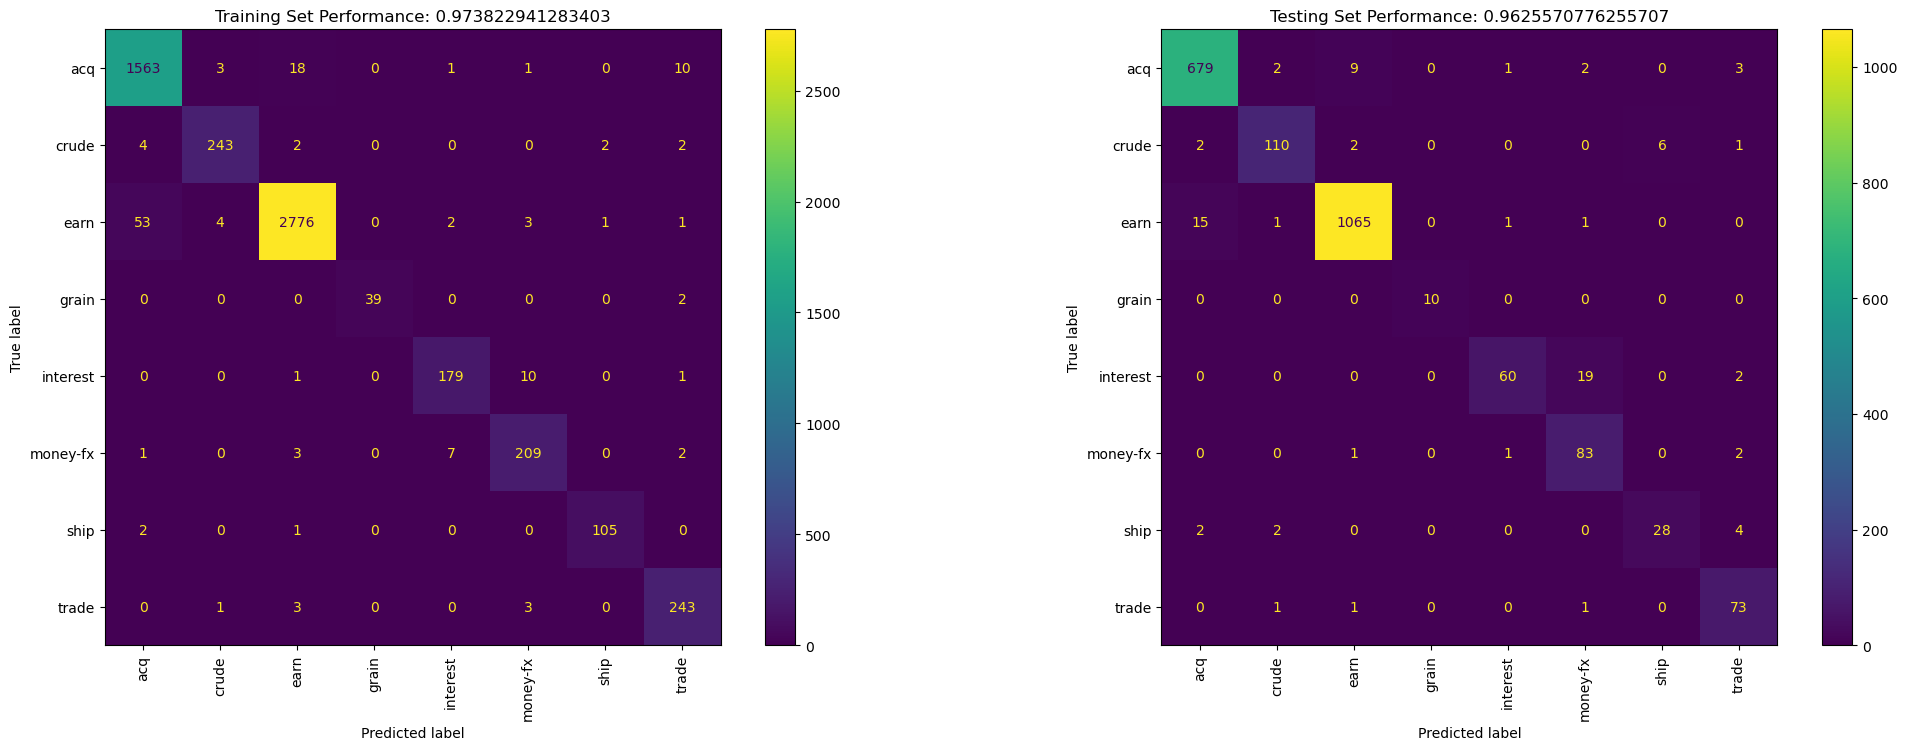

In [10]:
num_words = 10000
bow_representer = bow(train_docs, tokenizer=tokenize, max_features=num_words)
train_bow = transform_corpus(train_docs, bow_representer)
test_bow = transform_corpus(test_docs, bow_representer)

nb_start = time.process_time()
nb = MultinomialNB().fit(train_bow, train_labels)
nb_train_end = time.process_time()
eval_model(nb, train_bow, train_labels, test_bow, test_labels)
nb_eval_end = time.process_time()
print('Naive Bayes took %d second to train, and %d to evaluate' % (nb_train_end - nb_start, nb_eval_end - nb_train_end))

That worked a bit better, but the really cool thing is that even with 100 times more features, it was still really quick to train.

#### Turning off smoothing

Remember before when we talked about smoothing and how that was helpful. Let's turn it off.

/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


              precision    recall  f1-score   support

         acq       0.92      0.93      0.92       696
       crude       0.88      0.92      0.90       121
        earn       0.95      0.97      0.96      1083
       grain       1.00      0.40      0.57        10
    interest       0.87      0.57      0.69        81
    money-fx       0.73      0.75      0.74        87
        ship       0.94      0.42      0.58        36
       trade       0.72      0.91      0.80        76

    accuracy                           0.92      2190
   macro avg       0.88      0.73      0.77      2190
weighted avg       0.92      0.92      0.91      2190

Naive Bayes took 0 second to train, and 0 to evaluate


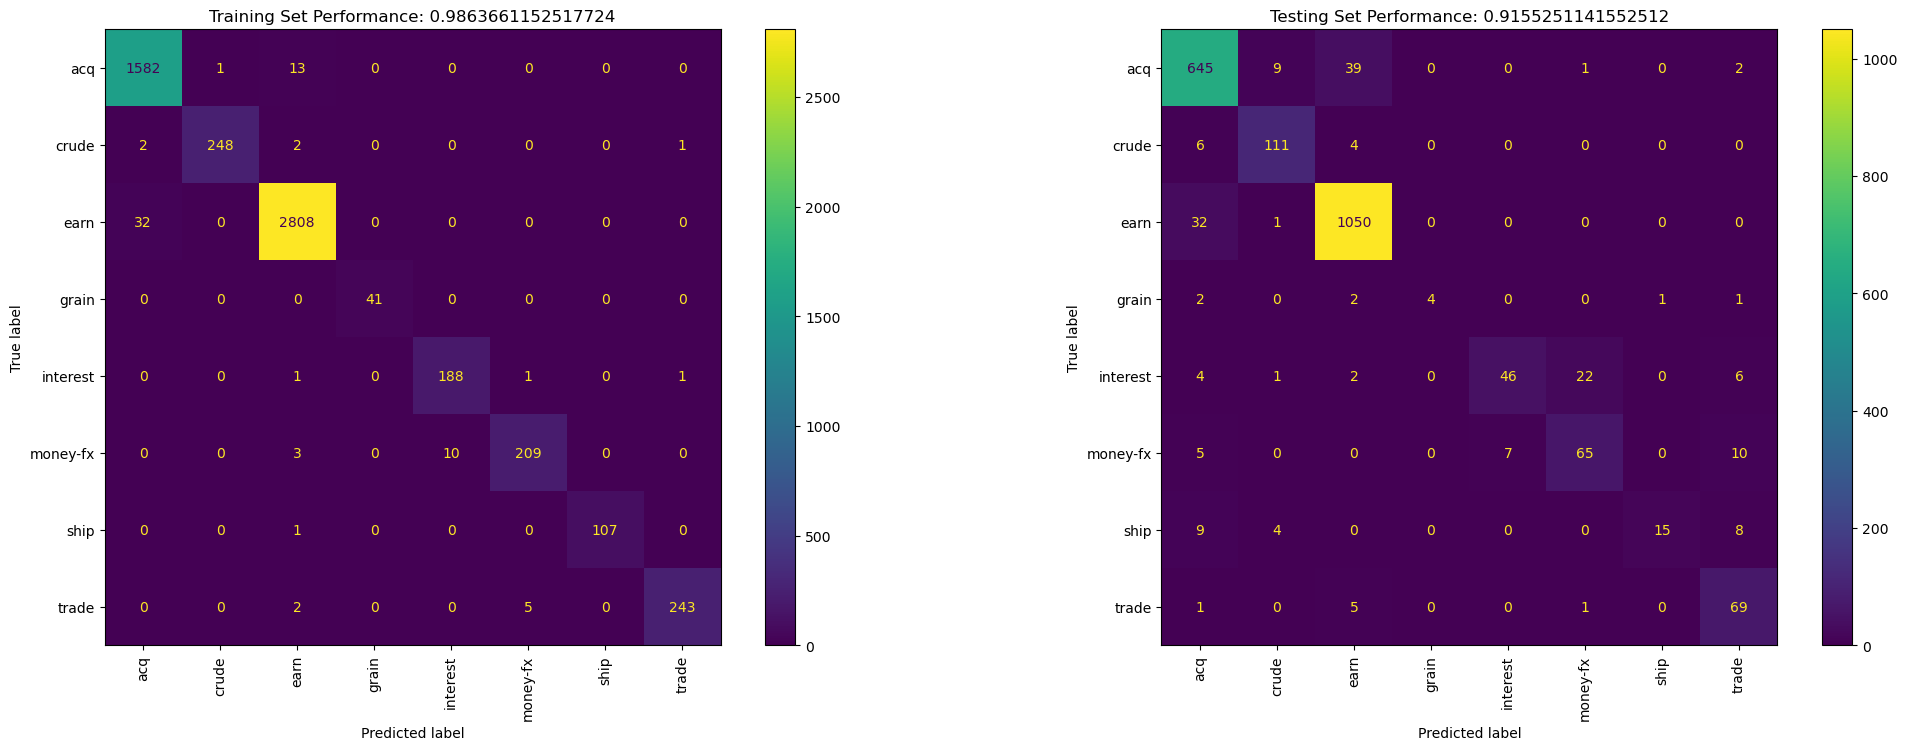

In [11]:
nb_start = time.process_time()
nb = MultinomialNB(alpha=0).fit(train_bow, train_labels)
nb_train_end = time.process_time()
eval_model(nb, train_bow, train_labels, test_bow, test_labels)
nb_eval_end = time.process_time()
print('Naive Bayes took %d second to train, and %d to evaluate' % (nb_train_end - nb_start, nb_eval_end - nb_train_end))

First up, we get a warning about turning it off and how that will cause "numeric errors" (i.e. shit to break). With it turned right down, which is all sklearn will let us do, we can see that we lose ~5% of performance.

#### Class Priors

Elsewhere, we've played a bit with class weights. Hopefully, a few of you reading this (is anybody out there?) had a minor epiphany earlier when we mentioned $P(y)$, the class prior. These are not class weights, but they don't look entirely dissimilar. These class priors effectivley tell Naive Bayes which classes to expect more often. So they prime the model to expect to see the common classes more often. This doesn't seem like it will promote class balance, but by turning this off and using a uniform class prior (i.e all classes are equally likely) we can remove any bias towards the more common classes - essentially achieving what we get from class weights.

              precision    recall  f1-score   support

         acq       0.96      0.98      0.97       696
       crude       0.95      0.92      0.93       121
        earn       0.99      0.98      0.98      1083
       grain       1.00      1.00      1.00        10
    interest       0.94      0.74      0.83        81
    money-fx       0.78      0.95      0.86        87
        ship       0.82      0.78      0.80        36
       trade       0.85      0.96      0.90        76

    accuracy                           0.96      2190
   macro avg       0.91      0.91      0.91      2190
weighted avg       0.96      0.96      0.96      2190

Naive Bayes took 0 second to train, and 0 to evaluate


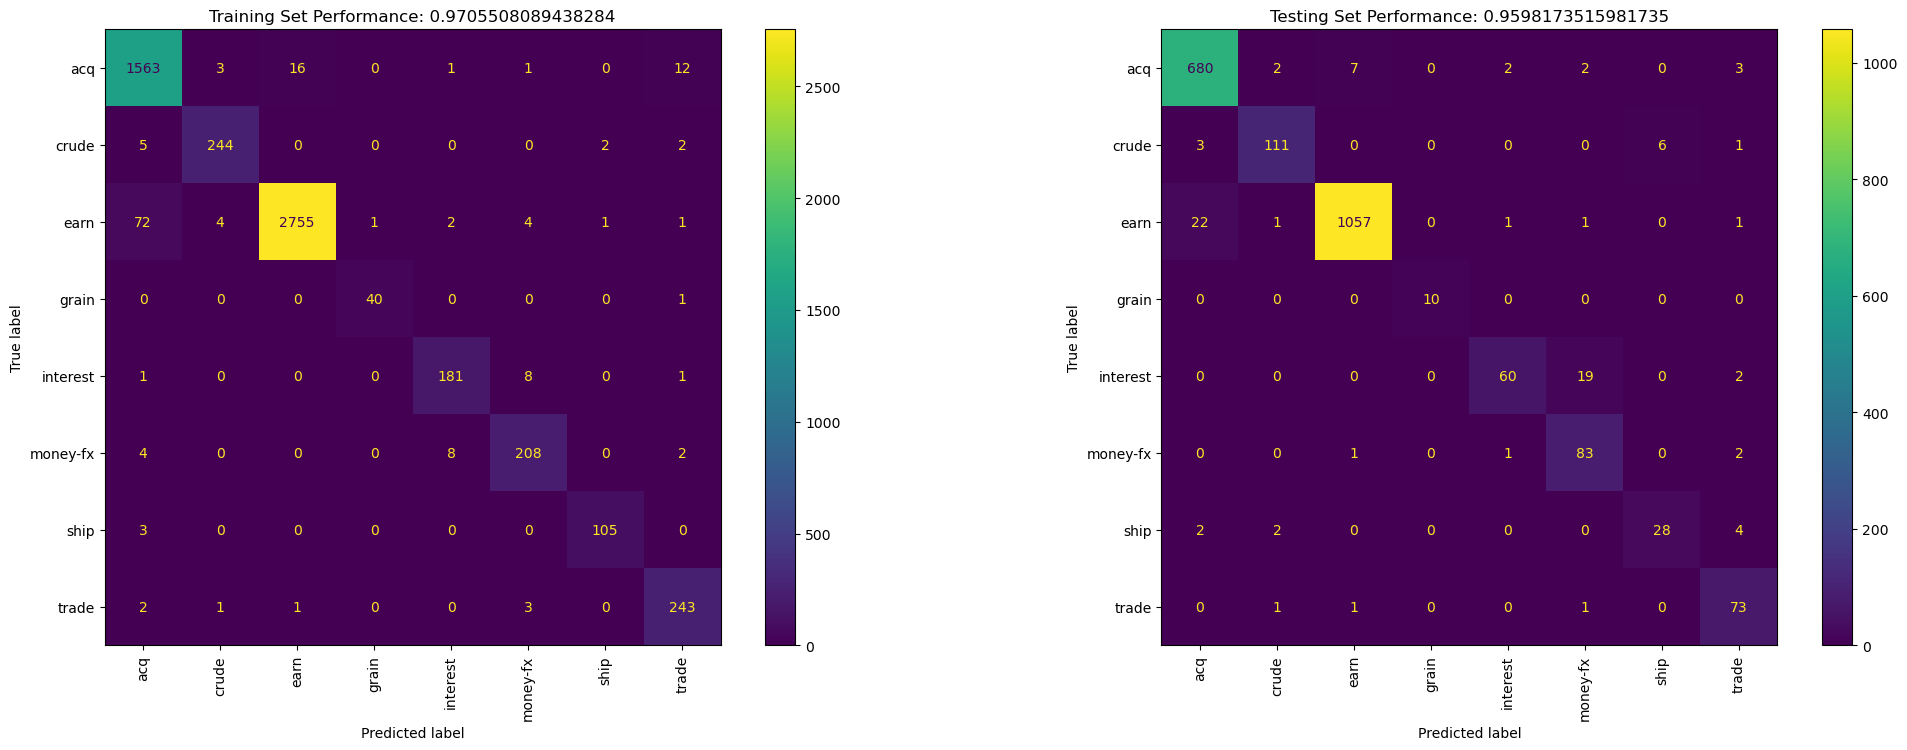

In [12]:
nb_start = time.process_time()
nb = MultinomialNB(fit_prior=False).fit(train_bow, train_labels)
nb_train_end = time.process_time()
eval_model(nb, train_bow, train_labels, test_bow, test_labels)
nb_eval_end = time.process_time()
print('Naive Bayes took %d second to train, and %d to evaluate' % (nb_train_end - nb_start, nb_eval_end - nb_train_end))

### Yet More Things

Writing this, and having scrolled back up just now, I'm wondering if anyone is left at this point. This has gone on for a while - and we've now covered the basics of BoW and Naive Bayes, but there are a couple of other things that I am going to cover. But if you need to leave now, I understand, and won't hold it against you.

#### N-Grams

We mentioned these briefly before. These allow us to consider short sequences of words. For demonstration, we'll use an ngram range of (2,3). This means that we'll build our dictionary from two and three word phrases. Note that we don't take any possible two and three word phrase (we're not throwing random words together), rather we're taking 2 and 3 word phrases that actually occur in the text. Let's look at them in practice.

In [13]:
num_words = 1000
bow_representer = bow(train_docs, tokenizer=tokenize, max_features=num_words, ngram_range=(2,3))
train_bow = transform_corpus(train_docs, bow_representer)
test_bow = transform_corpus(test_docs, bow_representer)
print(feature_values(train_docs[0], bow_representer))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[('addit share', 1), ('also said', 1), ('common stock', 2), ('compani said', 3), ('complet sale', 2), ('control compani', 1), ('dlr compani', 1), ('dlr compani said', 1), ('dlr per', 2), ('dlr per share', 2), ('dlr said', 1), ('five year', 1), ('hold pct', 1), ('inc said', 1), ('inc said complet', 1), ('market price', 1), ('mln share', 1), ('one mln', 1), ('outstand common', 1), ('outstand common stock', 1), ('per share', 2), ('price dlr', 1), ('purchas price', 1), ('said complet', 1), ('said move', 1), ('said sold', 1), ('said would', 1), ('share common', 1), ('share common stock', 1), ('system inc', 1)]


With a 1000 word dictionary, we can see that we've pulled out some simple phrases and built our dictionary with these. The big reason to do this is that this gives us extra context. For example the phrase "not good" is potentially far more informative than either "not" or "good" on their own.

This makes n-grams useful, but the catch is that the number of possible words starts to get even bigger. But in practice we may do something like this:

              precision    recall  f1-score   support

         acq       0.96      0.98      0.97       696
       crude       0.93      0.92      0.92       121
        earn       0.99      0.98      0.99      1083
       grain       1.00      0.80      0.89        10
    interest       0.95      0.72      0.82        81
    money-fx       0.77      0.92      0.84        87
        ship       0.96      0.61      0.75        36
       trade       0.77      0.99      0.87        76

    accuracy                           0.96      2190
   macro avg       0.92      0.86      0.88      2190
weighted avg       0.96      0.96      0.96      2190

Naive Bayes took 0 second to train, and 0 to evaluate


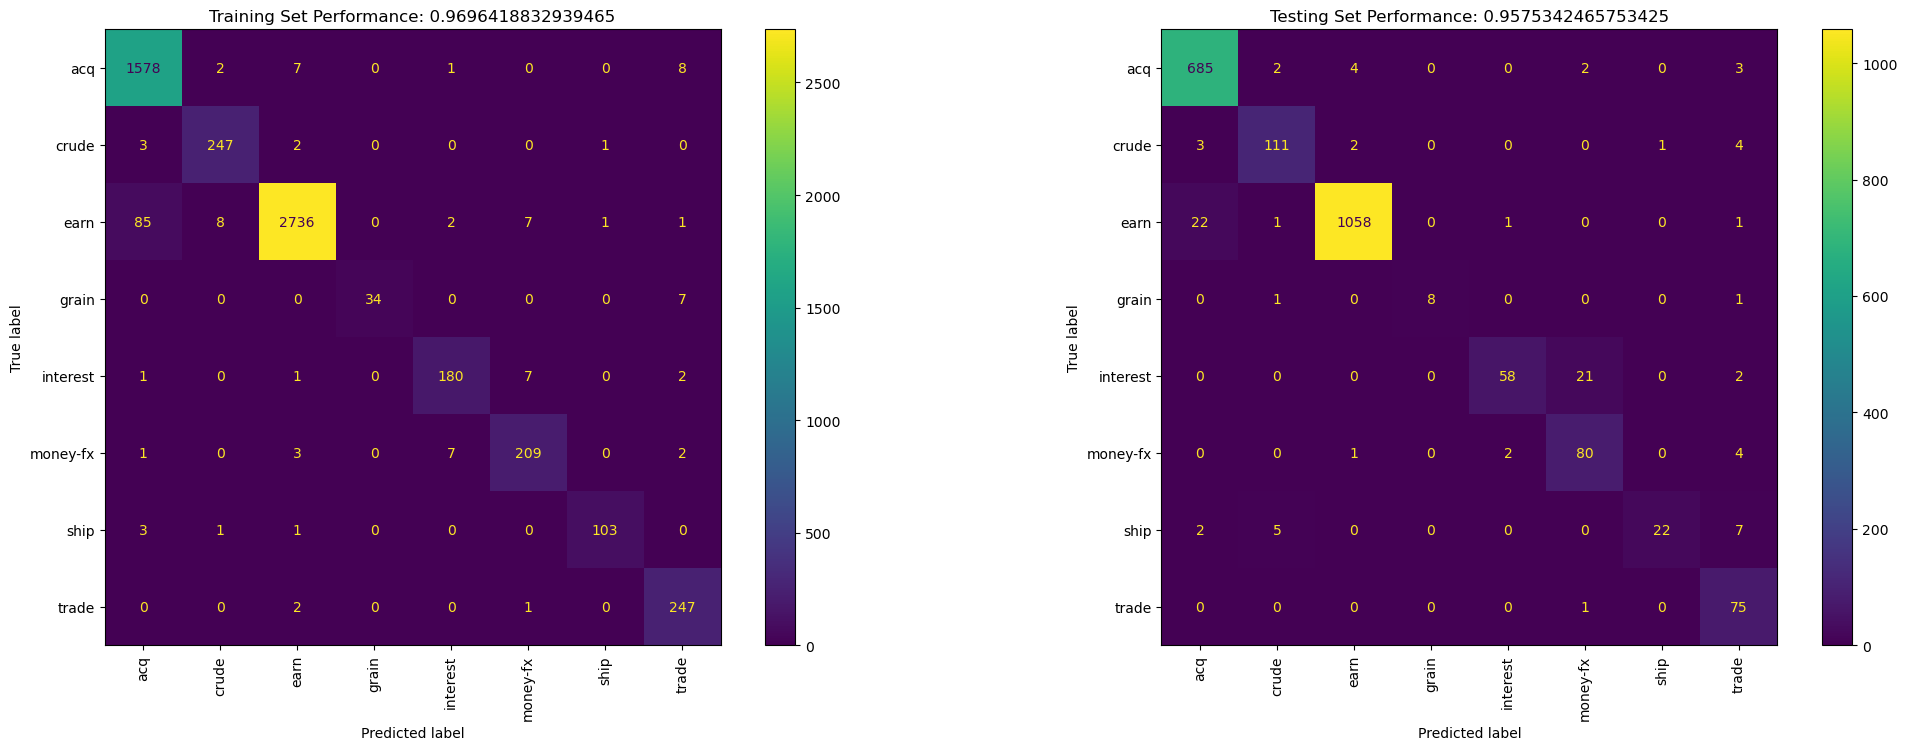

In [14]:
num_words = 20000
bow_representer = bow(train_docs, tokenizer=tokenize, max_features=num_words, ngram_range=(1,3))
train_bow = transform_corpus(train_docs, bow_representer)
test_bow = transform_corpus(test_docs, bow_representer)

nb_start = time.process_time()
nb = MultinomialNB().fit(train_bow, train_labels)
nb_train_end = time.process_time()
eval_model(nb, train_bow, train_labels, test_bow, test_labels)
nb_eval_end = time.process_time()
print('Naive Bayes took %d second to train, and %d to evaluate' % (nb_train_end - nb_start, nb_eval_end - nb_train_end))

This hasn't made a huge difference here - but when you're already running at 95% accuracy there's not really that far to go. Also, Naive Bayes is still running bloody fast.

#### TF-IDF

Yay! Another acronym!! This one means *Term Frequency - Inverse Document Frequency*. Still confused? Two weeks ago when you started reading this nonsense, I mentioned that a limitation of BoW was that document size could be a problem. Because we're just counting words, long documents will have more words and thus lead to bigger counts. As such, we may see inconsistencies from this. TF-IDF is one solution to this.

To get TF-IDF, we do the following:

$TF = \frac{\text{number of times the word appears in the document}}{\text{total number of words in the document}}$

$IDF = log(\frac{\text{total number of documents}}{\text{number of documents that contain the term}})$

$TFIDF = TF \times IDF$

So, to recap:
* TF (term frequency) is how often a term appears in a document. We get a TF vector for each document. Each of these will be the length of the dictionary. For words that never occur in the document, their TF will be 0
* IDF (inverse document frequency) is the inverse frequency of how often a term appears in all documents. For terms that are very rare (occur in very few documents) this will be big. For terms that occur in a lot of documents, this will be small
* TF-IDF is just the product of these two things. 

What this means is that TF-IDF will emphaise words that are common in the document, and uncommon elsewhere. It will help to highlight words that make the document the unique and precious snowflake that it is.

To use TF-IDF, we don't have to change a lot. We can just replace our previous BoW extractor with a TF-IDF one. I've got a function below that does much the same thing, and we can use that in much the same way.

We'll start with a little visualisation.

In [15]:
def tf_idf(docs, tokenizer=None, ngram_range = (1,1), min_df = 3, max_df = 0.90, max_features = 500):
    tfidf = TfidfVectorizer(tokenizer=tokenizer, min_df=min_df, max_df=max_df, \
                            max_features=max_features, ngram_range=ngram_range, \
                            use_idf=True, sublinear_tf=True, norm='l2');
    tfidf.fit(docs);
    return tfidf;

num_words = 100
tfidf_representer = tf_idf(train_docs, tokenizer=tokenize, max_features=num_words)
train_tfidf = transform_corpus(train_docs, tfidf_representer)
test_tfidf = transform_corpus(test_docs, tfidf_representer)

print(train_tfidf[0])
print(feature_values(train_docs[0], tfidf_representer))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  (0, 99)	0.08925289530957194
  (0, 98)	0.259746668826017
  (0, 93)	0.1531544880642414
  (0, 88)	0.21180696341539684
  (0, 83)	0.26110489733761577
  (0, 78)	0.20163985281688068
  (0, 77)	0.20507530929551093
  (0, 67)	0.15240964748074196
  (0, 65)	0.3014501457893948
  (0, 64)	0.14702602632319642
  (0, 63)	0.23752836734033198
  (0, 62)	0.17489143611675173
  (0, 61)	0.14071149390783214
  (0, 60)	0.12406192015824276
  (0, 59)	0.12494730530792199
  (0, 50)	0.07612784625113858
  (0, 46)	0.13537368517414497
  (0, 36)	0.14502762773065164
  (0, 35)	0.12474901875115724
  (0, 34)	0.14918849420961916
  (0, 33)	0.15875144349063233
  (0, 28)	0.15213352838498578
  (0, 21)	0.19135346384975577
  (0, 18)	0.15077816368289593
  (0, 16)	0.22866051990796307
  (0, 15)	0.3167991698096012
  (0, 13)	0.14793470062934658
  (0, 3)	0.21394730120635355
  (0, 0)	0.14440671429518154
[('year', 0.08925289530957194), ('would', 0.259746668826017), ('total', 0.1531544880642414), ('stock', 0.21180696341539684), ('share', 0.

We've replaced our raw counts with a frequency, but the overall vibe of the features is similar. Plots the TF-IDF vectors as histograms again has a similar feel.

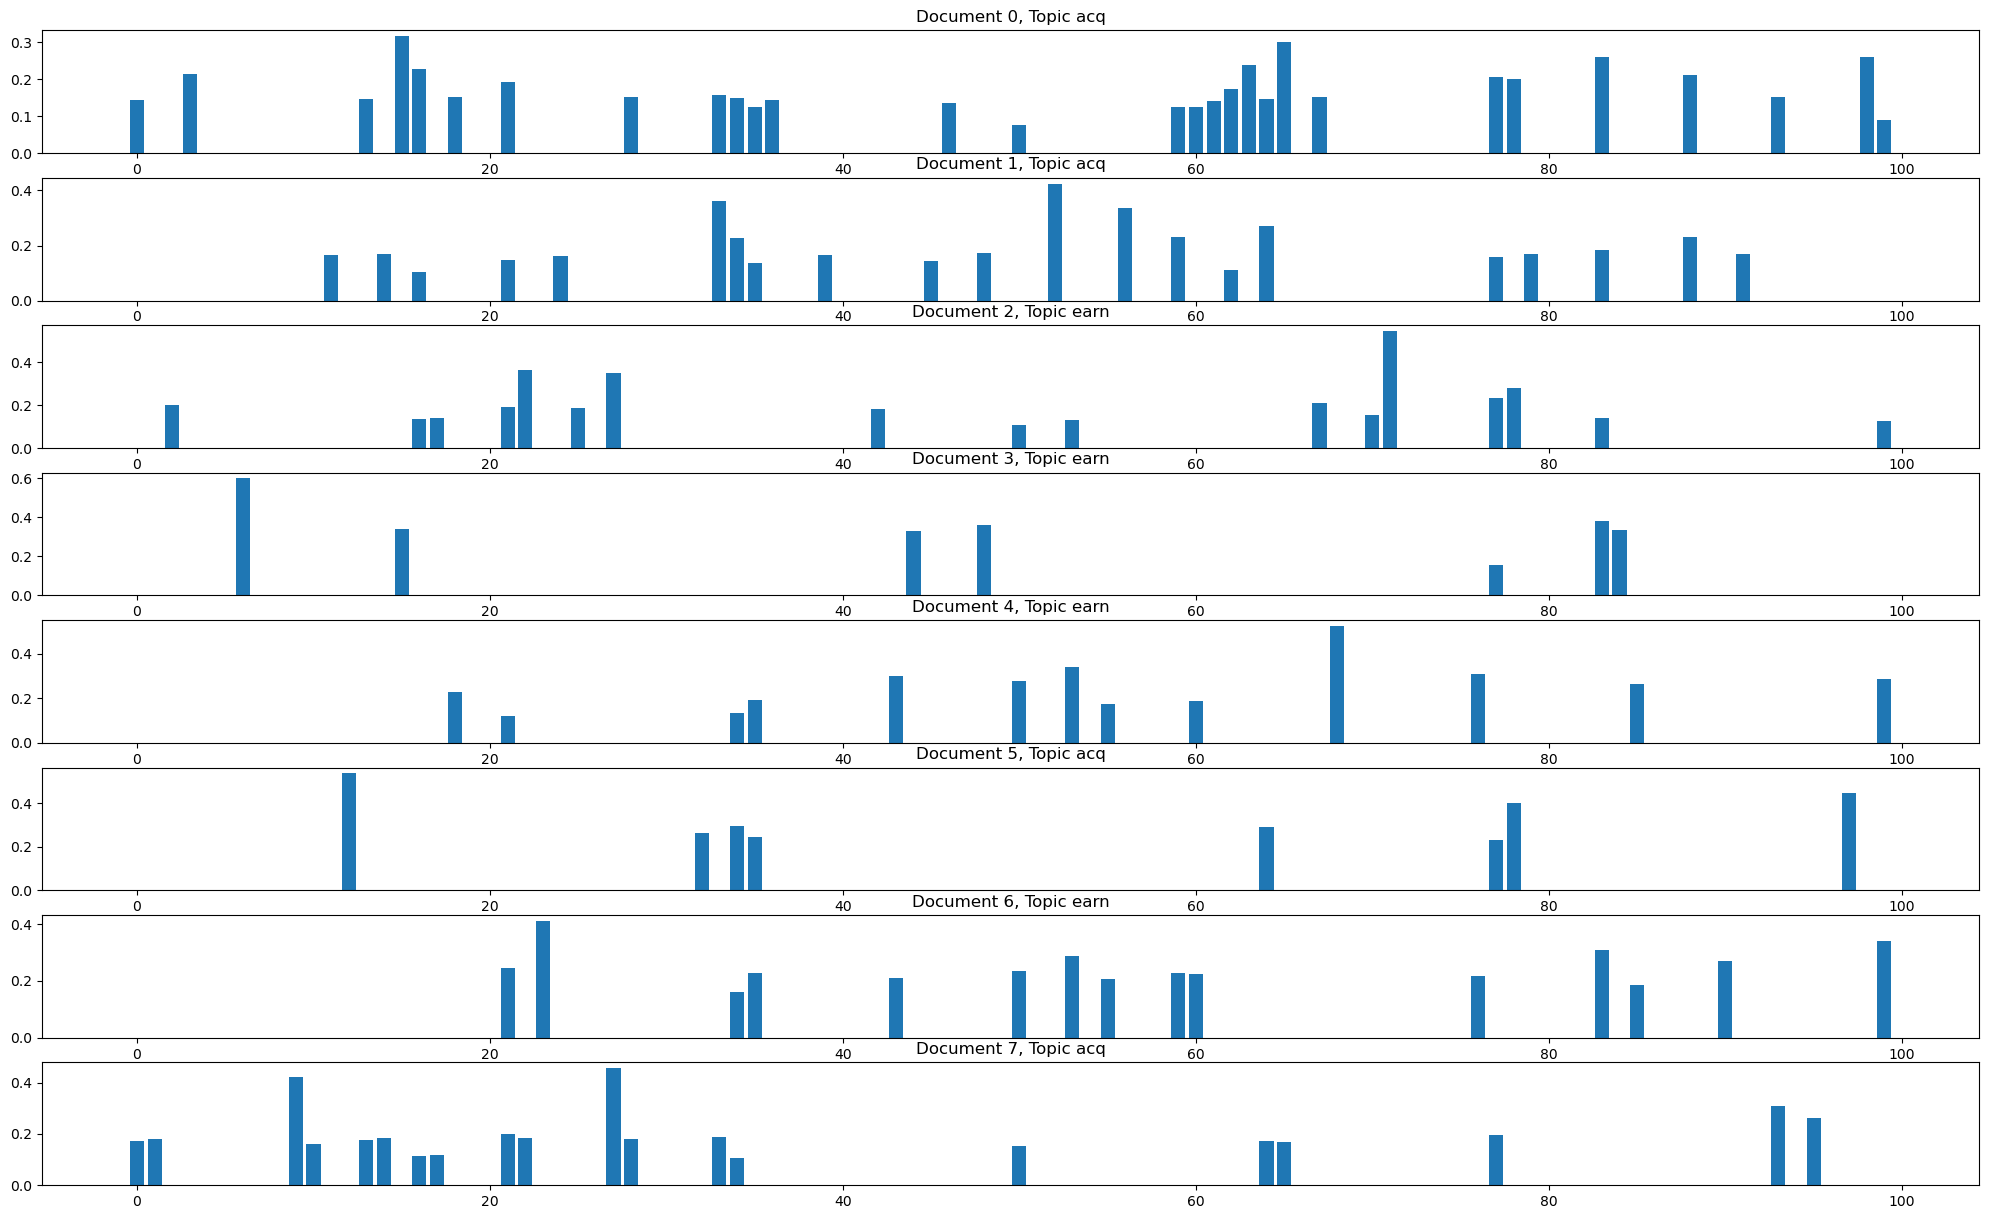

In [16]:
fig = plt.figure(figsize=[25, 15])
for i in range(num_plots):
    ax = fig.add_subplot(num_plots, 1, i+1)
    ax.bar(x = numpy.arange(0, num_words, 1), height = numpy.reshape(train_tfidf[i,:].toarray(), -1));
    ax.set_title('Document %d, Topic %s' % (i, train_labels[i]))

Let's throw TF-IDF at our Naive Bayes classifier.

One slightly odd thing here is that we're still using a multi-nomial version of naive Bayes, yet our data is now fractional (i.e. it's not following a multi-nomial distribution). While this does seem odd, this is multi-nomial NB is actually very commonly used with TF-IDF features, and tends to work quite well (and allows us to continue to use the sparse representation with sklearn's implementation).

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         acq       0.88      0.98      0.93       696
       crude       0.94      0.78      0.85       121
        earn       0.94      0.99      0.96      1083
       grain       0.00      0.00      0.00        10
    interest       1.00      0.30      0.46        81
    money-fx       0.78      0.68      0.72        87
        ship       1.00      0.14      0.24        36
       trade       0.71      0.76      0.73        76

    accuracy                           0.91      2190
   macro avg       0.78      0.58      0.61      2190
weighted avg       0.91      0.91      0.89      2190

Naive Bayes took 0 second to train, and 0 to evaluate


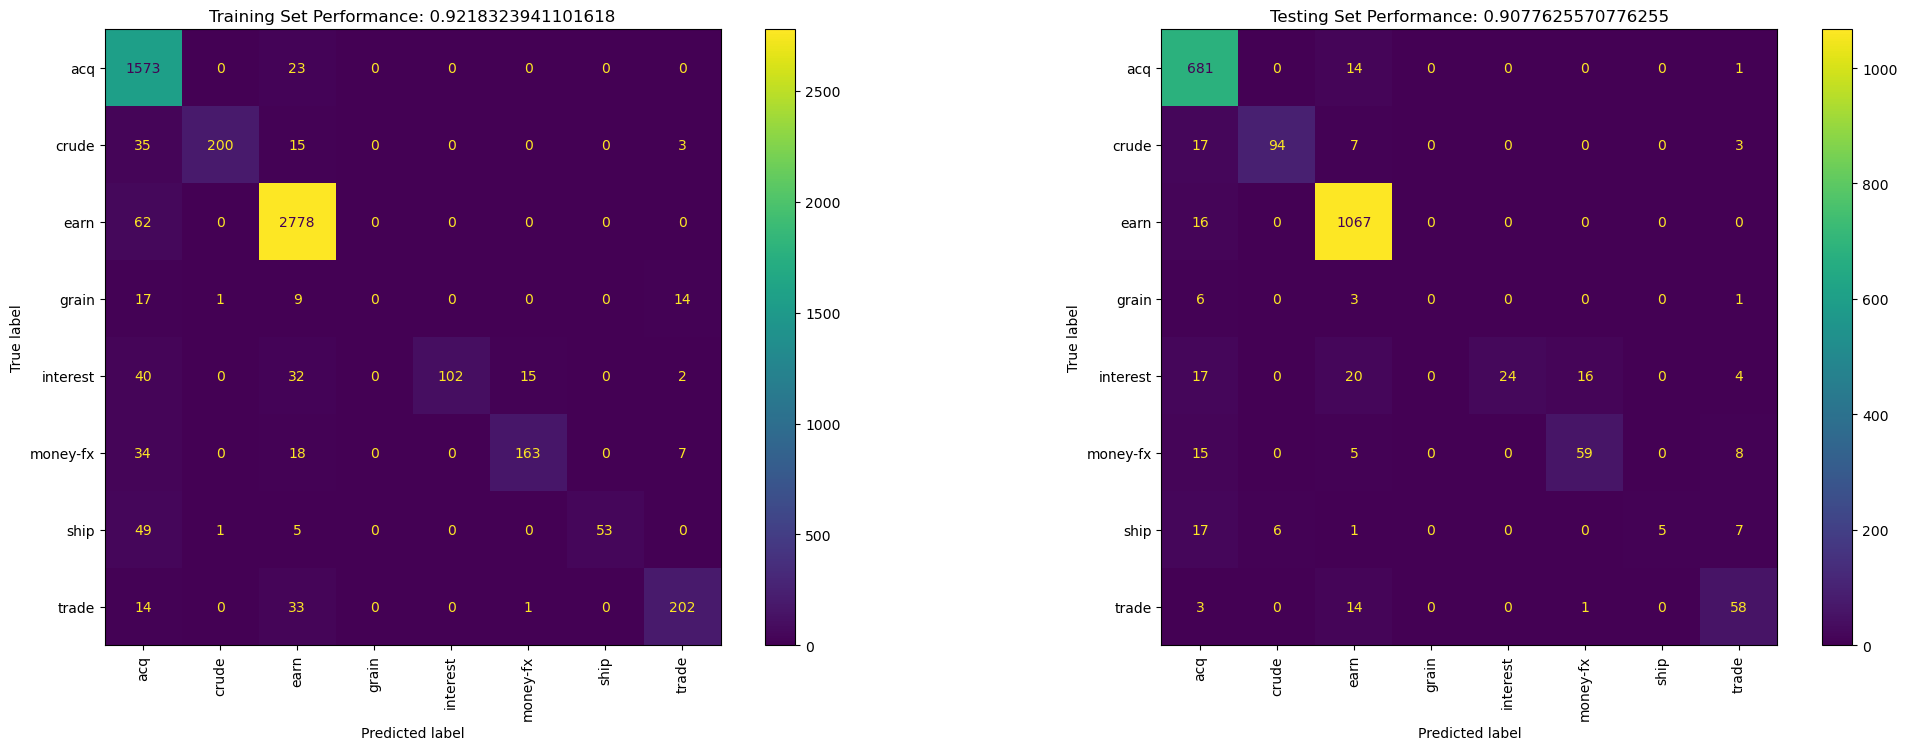

In [17]:
num_words = 10000
tfidf_representer = tf_idf(train_docs, tokenizer=tokenize, max_features=num_words)
train_tfidf = transform_corpus(train_docs, tfidf_representer)
test_tfidf = transform_corpus(test_docs, tfidf_representer)

nb_start = time.process_time()
nb = MultinomialNB().fit(train_tfidf, train_labels)
nb_train_end = time.process_time()
eval_model(nb, train_tfidf, train_labels, test_tfidf, test_labels)
nb_eval_end = time.process_time()
print('Naive Bayes took %d second to train, and %d to evaluate' % (nb_train_end - nb_start, nb_eval_end - nb_train_end))

This works ok. We've actually lost a little bit here, which is perhaps down to either:
* Our dictionary size or other parameters being sub-optimal
* Our documents already being somewhat uniform in length (they're all news articles), so issues with word counts being out of whack aren't as bad

In general, TF-IDF will give an improvement, but it won't always. Also, we've not made any attemps a grid search here, so it's hard to say what the best system here really is anyway.

### Final Thoughts

I'll keep this brief, you've been here a while:
* BoW and TF-IDF give us a way to take a variable length input and make it fixed length. Though this fixed length may be quite big.
* Long features may demand a different classifier. Naive Bayes, despite it's flawed (and Naive) assumptions works quite well; and is for all intents and purposes parameter free; meaning that any hyper-parameter search can simply focus on the dictionary parameters and use Naive Bayes as is.